1. 搭建的神经网络，使用olivettiface数据集进行训练。
2. 结合归一化和正则化来优化网络模型结构，观察对比loss结果。
3. 尝试不同optimizer对模型进行训练，观察对比loss结果。

In [17]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [18]:
olivetti_face=fetch_olivetti_faces(data_home="../第一周_2025_3_16学习内容/face_data",shuffle=True)

[0.76859504 0.75619835 0.74380165 ... 0.48347107 0.6280992  0.6528926 ]
30


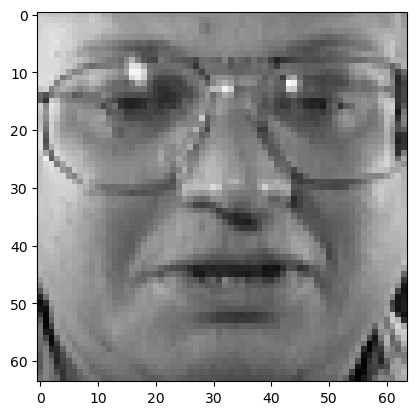

In [19]:
print(olivetti_face.data[1])
print(olivetti_face.target[1])
im_face=olivetti_face.images[1]
plt.imshow(im_face,cmap="gray")
plt.show()


In [20]:
#超参数设置
epochs=20
lr=0.01
batch_size=64

In [21]:
#数据导入转换
x = torch.tensor(olivetti_face.data)
y = torch.tensor(olivetti_face.target)

#查看数据类别有多少
print(len(torch.unique(y)))
#查看数据维度
print(x.shape)
print(y.shape)

40
torch.Size([400, 4096])
torch.Size([400])


In [22]:
x_data,y_data,x_tg,y_tg = train_test_split(x,y,test_size=0.2)
print(x_data.shape)
print(x_tg.shape)

torch.Size([320, 4096])
torch.Size([320])


In [23]:
#数据整理
train_ds = TensorDataset(x_data,x_tg)
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True)
test_ds = TensorDataset(y_data,y_tg)
test_dl = DataLoader(test_ds,batch_size=batch_size,shuffle=True)

- 一、搭建的神经网络，使用olivettiface数据集进行训练。

In [24]:
#定义模型
class Mymodel_1(nn.Module):
    def __init__(self):
        super(Mymodel_1,self).__init__()
        self.linear = nn.Linear(4096,2048)
        self.rl = nn.ReLU()
        self.linear2 = nn.Linear(2048,784)
        self.rl = nn.ReLU()
        self.linear3 = nn.Linear(784,40)
        
    def forward(self,x):
        out = self.linear(x)
        out = self.rl(out)
        out = self.linear2(out)
        out = self.rl(out)
        final = self.linear3(out)
        return final   

- 二、搭建的神经网络，使用fetch_olivetti_faces 数据集进行训练。

In [25]:
#定义模型
class Mymodel_2(nn.Module):
    def __init__(self):
        super(Mymodel_2,self).__init__()
        self.linear = nn.Linear(4096,2048)
        self.bs = nn.BatchNorm1d(2048)
        self.rl = nn.ReLU()
        self.linear2 = nn.Linear(2048,784)
        self.bs2 = nn.BatchNorm1d(784)
        self.rl = nn.ReLU()
        self.dp = nn.Dropout(0.1)
        self.linear3 = nn.Linear(784,40)
        
    def forward(self,x):
        out = self.linear(x)
        outa = self.bs(out)
        out = self.rl(out)
        out = self.linear2(out)
        out = self.bs2(out)
        out = self.rl(out)
        out = self.dp(out)
        final = self.linear3(out)
        return final        

- 三、尝试不同optimizer对模型进行训练，观察对比loss结果。

In [26]:
#定义多个模型
class Mymodel_3(nn.Module):
    def __init__(self):
        super(Mymodel_3,self).__init__()
        self.models=nn.ModuleList([
            nn.Sequential(
                nn.Linear(4096,2048),
                nn.BatchNorm1d(2048),
                nn.ReLU(),
                nn.Linear(2048,784),
                nn.BatchNorm1d(784),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(784,40)
            ) for _ in range(3)
        ]
        )
    def forward(self,x):
        for model in self.models:
            final = model(x)
        return final
    
    def __iter__(self):
        
        return iter(self.models)
    
    def __len__(self):
        
        return len(self.models)

In [27]:
#进行模型训练
def train(epochs, model, lr, train_dl,test_dl):
    #损失函数、优化器设置
    
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    
    loss_hist = []
    for epoch in range(epochs):
        model.train()
        for data,target in train_dl:
            out = model(data)
            loss_val = loss(out,target.long())
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
        
        model.eval()
        running_loss = 0.0 #初始化损失
        correct = 0 
        total = 0
        with torch.no_grad():
            for data,target in test_dl:
                out = model(data)
                loss_val=loss(out,target.long())
                
                _,pred = torch.max(out,1)
                running_loss += loss_val.item()
                correct += (pred==target).sum().item()
                total += target.size(0)
                
        hist_l = running_loss/len(test_dl)
        loss_hist.append(hist_l)
        Acc = correct/total*100
        if epoch % 5 == 0:
            print(f"Epoch:{epoch},Loss:{hist_l:.4f},Acc:{Acc:.4f}")
            
    return loss_hist
    

In [28]:
#汇总每个模型
model_1 = Mymodel_1()
model_2 = Mymodel_2()
model_3 = Mymodel_3()
m1 = train(epochs,model_1,lr,train_dl,test_dl)
m2 = train(epochs,model_2,lr,train_dl,test_dl)
m3 =  [train(epochs,model,lrr,train_dl,test_dl) for model,lrr in zip(model_3,[0.1,0.01,0.001])]

Epoch:0,Loss:8.8744,Acc:0.0000
Epoch:5,Loss:3.7197,Acc:1.2500
Epoch:10,Loss:3.6313,Acc:2.5000
Epoch:15,Loss:3.8039,Acc:1.2500
Epoch:0,Loss:79.5719,Acc:3.7500
Epoch:5,Loss:6.9818,Acc:6.2500
Epoch:10,Loss:4.9553,Acc:33.7500
Epoch:15,Loss:1.7285,Acc:63.7500
Epoch:0,Loss:1437.3212,Acc:0.0000
Epoch:5,Loss:3.9687,Acc:31.2500
Epoch:10,Loss:1.2887,Acc:77.5000
Epoch:15,Loss:0.9570,Acc:80.0000
Epoch:0,Loss:200.4310,Acc:0.0000
Epoch:5,Loss:3.4162,Acc:42.5000
Epoch:10,Loss:0.7925,Acc:88.7500
Epoch:15,Loss:0.5841,Acc:90.0000
Epoch:0,Loss:6.2302,Acc:3.7500
Epoch:5,Loss:0.9582,Acc:82.5000
Epoch:10,Loss:0.3639,Acc:93.7500
Epoch:15,Loss:0.3186,Acc:93.7500


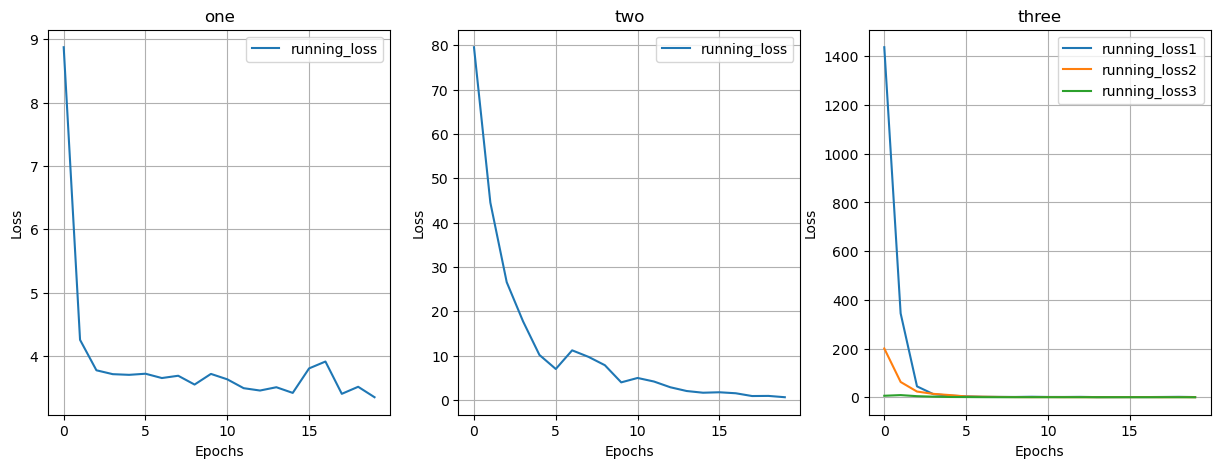

In [30]:
#设置图纸大小
plt.figure(figsize=(15, 5))
#画出训练的第一个模型
plt.subplot(1,3,1)
plt.plot(m1,label=f"running_loss")
plt.title("one")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
#画出训练的第二个模型
plt.subplot(1,3,2)
plt.plot(m2,label=f"running_loss")
plt.title("two")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
#画出训练的第三个模型
plt.subplot(1,3,3)
for i,hist in enumerate(m3):
    plt.plot(hist,label=f"running_loss{i+1}")
plt.title("three")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()